# Import

In [4]:

import matplotlib.pyplot as plt
import sys
import os
from tqdm import tqdm
import scipy.io as sio
import seaborn as sns

sys.path.append(os.path.abspath("../src"))

from utils.mpiifacegaze_dataset import *
import torch
from torch.utils.data import DataLoader
from tracker import GazeModel
from utils.mpiifacegaze_dataset import *

from sklearn.model_selection import GroupKFold

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
print(f"{torch.cuda.get_device_name(torch.cuda.current_device())}")

Quadro P1000


# Preprocessing - Stats

In [7]:
dataset = MPIIFaceGazeDataset(root_dir='../dataset/MPIIFaceGaze/')
df_mpi = dataset.to_dataframe(normalize=False)

In [9]:
print(df_mpi.head())

  subject                                    img_path  gaze_x  gaze_y
0     p00  ../dataset/MPIIFaceGaze/p00/day01/0005.jpg   476.0   758.0
1     p00  ../dataset/MPIIFaceGaze/p00/day01/0030.jpg  1078.0   693.0
2     p00  ../dataset/MPIIFaceGaze/p00/day01/0031.jpg   126.0   598.0
3     p00  ../dataset/MPIIFaceGaze/p00/day01/0038.jpg   211.0    69.0
4     p00  ../dataset/MPIIFaceGaze/p00/day01/0063.jpg   878.0   752.0


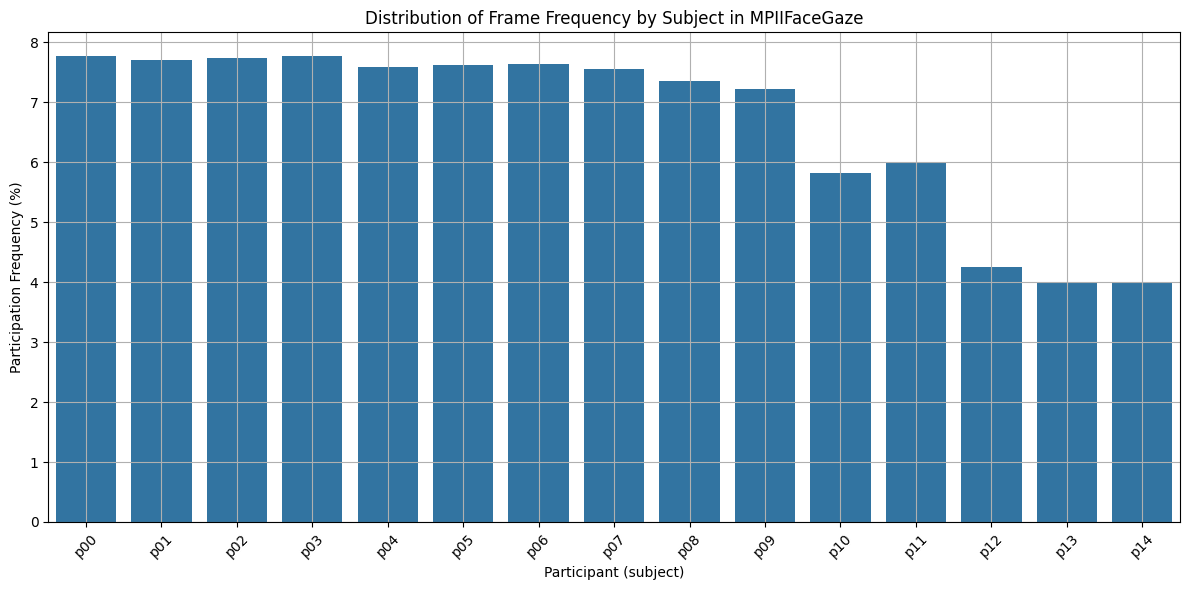

In [9]:
subject_counts = df_mpi['subject'].value_counts(normalize=True).sort_index() * 100

plt.figure(figsize=(12, 6))
sns.barplot(x=subject_counts.index, y=subject_counts.values)
plt.xticks(rotation=45)
plt.xlabel('Participant (subject)')
plt.ylabel('Participation Frequency (%)')
plt.title('Distribution of Frame Frequency by Subject in MPIIFaceGaze')
plt.tight_layout()
plt.grid(True)
plt.show()


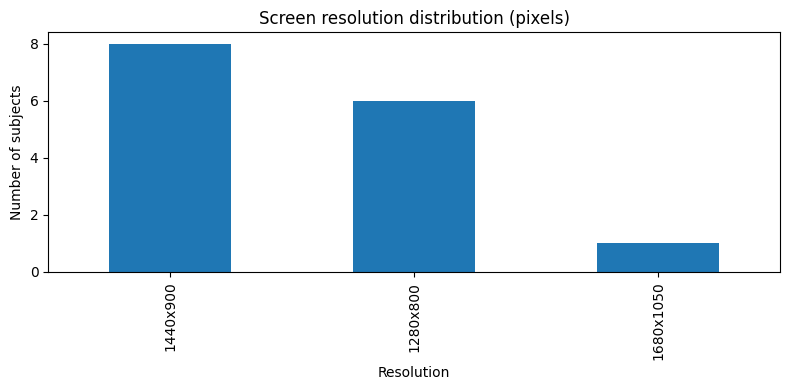

In [6]:
dataset.plot_screen_size_histogram()

In [10]:
df = dataset.to_dataframe(normalize=True)

In [ ]:
#generate_means(df)

I0000 00:00:1752070211.829002   48044 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1752070211.831459   48127 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) UHD Graphics 630 (CFL GT2)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
Computing mean tensors:   0%|          | 0/1178 [00:00<?, ?it/s]W0000 00:00:1752070211.836322   48114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752070211.858041   48113 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752070211.860968   48120 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
Computing mean tensors: 100%|█

Means saved successfully in:
  → ../src/mat/mean_face_224_MPIIFace.mat
  → ../src/mat/mean_left_224_MPIIFace.mat
  → ../src/mat/mean_right_224_MPIIFace.mat


In [24]:
df_skipped = pd.read_csv("skipped_images.csv",delimiter=" ")
df_skipped


,Exception,img_path
[NO,FACE],../dataset/MPIIFaceGaze/p07/day33/0346.jpg
[NO,FACE],../dataset/MPIIFaceGaze/p07/day33/0353.jpg
[NO,FACE],../dataset/MPIIFaceGaze/p07/day33/0356.jpg
[NO,FACE],../dataset/MPIIFaceGaze/p07/day33/0358.jpg
[NO,FACE],../dataset/MPIIFaceGaze/p07/day33/0363.jpg
...,...,...
[NO,FACE],../dataset/MPIIFaceGaze/p12/day04/0121.jpg
[NO,FACE],../dataset/MPIIFaceGaze/p12/day04/0122.jpg
[NO,FACE],../dataset/MPIIFaceGaze/p12/day04/0125.jpg
[NO,FACE],../dataset/MPIIFaceGaze/p12/day04/0127.jpg


In [25]:
df_clean = df[~df["img_path"].isin(df_skipped["img_path"])]

In [26]:
len(df), len(df_clean)

(37667, 37600)

In [27]:
groups = np.array(df_clean["subject"])
X, y = np.array(df_clean["img_path"]), np.array(df_clean[["gaze_x","gaze_y"]])

In [28]:
gkf = GroupKFold(n_splits=5)
gkf.get_n_splits(X,y,groups)
print(gkf)

GroupKFold(n_splits=5, random_state=None, shuffle=False)


In [36]:
for train_idx, test_idx in gkf.split(df_clean, groups=df_clean['subject']):
    df_train = df_clean.iloc[train_idx]
    df_test = df_clean.iloc[test_idx]

In [37]:
df_train

,subject,img_path,gaze_x,gaze_y
0,p00,../dataset/MPIIFaceGaze/p00/day01/0005.jpg,0.371875,0.947500
1,p00,../dataset/MPIIFaceGaze/p00/day01/0030.jpg,0.842187,0.866250
2,p00,../dataset/MPIIFaceGaze/p00/day01/0031.jpg,0.098437,0.747500
3,p00,../dataset/MPIIFaceGaze/p00/day01/0038.jpg,0.164844,0.086250
4,p00,../dataset/MPIIFaceGaze/p00/day01/0063.jpg,0.685937,0.940000
...,...,...,...,...
37662,p14,../dataset/MPIIFaceGaze/p14/day07/0196.jpg,0.506944,0.153333
37663,p14,../dataset/MPIIFaceGaze/p14/day07/0197.jpg,0.668750,0.892222
37664,p14,../dataset/MPIIFaceGaze/p14/day07/0198.jpg,0.929861,0.890000
37665,p14,../dataset/MPIIFaceGaze/p14/day07/0199.jpg,0.945833,0.102222


In [39]:
train_dataset = FaceGazeDataset(df_train)
test_dataset = FaceGazeDataset(df_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


I0000 00:00:1752158198.505946   17182 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1752158198.508035   18822 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) UHD Graphics 630 (CFL GT2)
W0000 00:00:1752158198.511626   18812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1752158198.515976   17182 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1752158198.518216   18837 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: Mesa Intel(R) UHD Graphics 630 (CFL GT2)


W0000 00:00:1752158198.524223   18825 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752158198.531378   18811 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752158198.541371   18826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [40]:
model = GazeModel().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 20

In [41]:
for epoch in range(epochs):
    total_loss = 0

    for face, eye_left, eye_right, face_grid , gaze in train_loader:
        face, eye_left, eye_right, face_grid, gaze = (
                    face.to(device),
                    eye_left.to(device),
                    eye_right.to(device),
                    face_grid.to(device),
                    gaze.to(device)
                )

        optimizer.zero_grad()
    
        pred = model(face, eye_left, eye_right, face_grid)

        loss = criterion(pred, gaze)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

KeyboardInterrupt: 